In [1]:
import os
from prophet import Prophet
import numpy as np
import pandas as pd
import itertools
from prophet.diagnostics import cross_validation

from google.cloud import bigquery


import json
from prophet.serialize import model_to_json, model_from_json

from datetime import datetime, timedelta

import sklearn.metrics as metrics
import pandas_gbq

# from pmdarima import auto_arima
# from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
# from statsmodels.tsa.stattools import adfuller
# from pmdarima.arima import ADFTest
# from statsmodels.tsa.arima_model import ARIMA
# from statsmodels.tsa.stattools import acf, pacf
# import statsmodels.api as sm
# from pmdarima.arima import auto_arima

import uuid 

import import_ipynb


import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

In [ ]:
from prepare_data import PL_events

from Utilities import generate_prophet_time_frame,initialize_model_db,initialize_forecast_db,save_pandas_dataframe

from main import timedata,model_build,data_extended

importing Jupyter notebook from prepare_data.ipynb


In [3]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'C:/cloud/gcs_service_account.json'
bqclient = bigquery.Client()

model_directory="C:\modeldb\sample"


#Time Series Parameters
Parameters= {"vxp_client_id": 1 , 
             "metric":"DAU",
            "game":'All',
            "platform" : 'All'}


#Bigquery parameters
project_id="project1-327507"
dataset="forecasts"
model_table=f"{dataset}.model{Parameters['metric']}"
forecast_table=f"{dataset}.forecasts_{Parameters['metric']}"

In [4]:
#These functions should be moved to utilities
#Functions to write model output to bigquery 
def write_model_db_to_bq(model_output_data,parameters):
    model_output_data.update(parameters)
    print(model_output_data)
    
    pandas_gbq.to_gbq(dataframe=pd.DataFrame(model_output_data),
                  destination_table=model_table ,
                  project_id=project_id,
                  if_exists='append')

def write_forecasts_to_bq(forecasts_df):    
    pandas_gbq.to_gbq(forecasts_df,
                  destination_table=forecast_table ,
                  project_id=project_id,
                  if_exists='append')

    
    
def read_model_db_from_bq(Parameters):
    try :
        query_string=f"""
        SELECT
        *
        FROM `{project_id}.{model_table}` 
        where 
        vxp_client_id={Parameters['vxp_client_id']} 
        order by model_training_date desc limit 1 """
#         print(query_string)
        model_df = (
        bqclient.query(query_string)
        .result()
        .to_dataframe(
            # Optionally, explicitly request to use the BigQuery Storage API. As of
            # google-cloud-bigquery version 1.26.0 and above, the BigQuery Storage
            # API is used by default.
            create_bqstorage_client=True,
                    )
                )
        
        model_id=model_df['model_id'].iloc[0]
        model_path=model_df['model_path'].iloc[0]
        return model_df,model_id,model_path
    except :
        print("Model DB is not created yet")
        return None
    
def read_forecast_db_from_bq(model_id):
    
    try :
        query_string=f"""
        SELECT
        *
        FROM `{project_id}.{forecast_table}` 
        where 
        model_id='{model_id}' 
        order by ds 
         """
        print(query_string)
        forecast_df = (
        bqclient.query(query_string)
        .result()
        .to_dataframe(
            # Optionally, explicitly request to use the BigQuery Storage API. As of
            # google-cloud-bigquery version 1.26.0 and above, the BigQuery Storage
            # API is used by default.
            create_bqstorage_client=True,
                    )
                )
        return forecast_df
    except :
        print("Forecasts not found")
        

def benchmark(yhat,yhat_lower,yhat_upper,y):
    if y > yhat_upper or y < yhat_lower :
        print("Outside of confidence intervals")
    
    else :
        print("Inside confidence interval")
    
def load_model(model_path):
    with open(model_path, 'r') as fin:
        m = model_from_json(json.load(fin))  # Load model
    return m



In [5]:
# df_read=read_model_db_from_bq(Parameters)

In [6]:
PL_events.tail(2)

,checkpoint,count_players
date,,
2021-11-07,2021-11-07,135738
2021-11-08,2021-11-08,133056


In [7]:
#Steps brainstorming 

#What we have 
#1- Current Date (run_date)
#2- Time series that we will be working on (vxp_client_id , metric , game, platform)



# Steps


#Query bigquery model_db table using the parameters given
# if model exists retrieve the model parameters and model_path
    #Load the model using the model path 
    #Instantiate the model_build class using the old model 
    
    #query forecast db to calculate previous forecasts and just produce the error between actual(incoming data) and forecasts
    
#if model doesnot exist 
    #Instantiate the model_build class
    

#
    
#Decide on the best possible training (either fitting from scratch , forecasting ,)
#Initially we can create a dummy function that ouputs window of training,training type





#

In [7]:
PL_events_i=data_extended(PL_events)
train,test=PL_events_i.hold_out_data(0.2)

# model_db,forecast_db=initialize_model_db(),initialize_forecast_db()


In [8]:
model_prophet=model_build()


In [9]:
model_prophet.fit(train_data=train.append(test),measure="count_players")
model_output=model_prophet.evaluate()
new_forecast_db=model_prophet.forecast(forecast_steps=50)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Train data is between 01-05-2021 and 08-11-2021
Train Mean Absolute Error: 3479.65405894711
Forecasts between 09-11-2021 and 28-12-2021 



In [10]:
new_forecast_db.head(2)

,ds,yhat,yhat_lower,yhat_upper,model_id
0,2021-11-09,143018.357327,136553.440686,149254.084593,0a861f9f-20b7-463c-900c-8d4833d26ffb
1,2021-11-10,142525.435538,136164.321639,148737.743179,0a861f9f-20b7-463c-900c-8d4833d26ffb


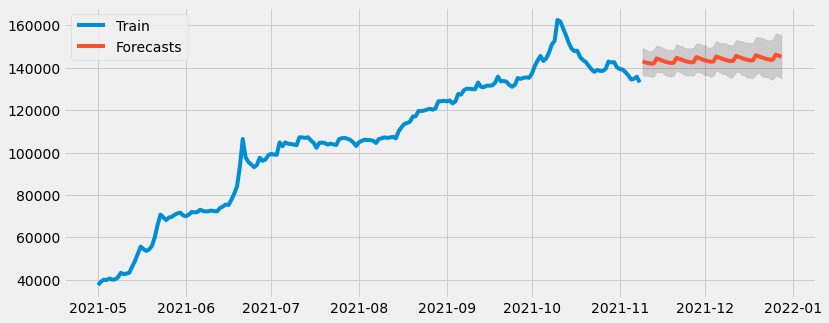

In [11]:
model_prophet.plot()

In [12]:
write_model_db_to_bq(model_output,Parameters)

{'model_id': [UUID('0a861f9f-20b7-463c-900c-8d4833d26ffb')], 'model_path': ['C:\\modeldb\\sample\\0a861f9f-20b7-463c-900c-8d4833d26ffb.json'], 'model_type': ['Prophet'], 'model_training_date': ['2021-12-29, 02:22:56'], 'model_train_starttime': [Timestamp('2021-05-01 00:00:00')], 'model_train_endtime': [Timestamp('2021-11-08 00:00:00')], 'time_complexity': [0.8688082695007324], 'model_test_starttime': [None], 'model_test_endtime': [None], 'training_type': ['fit'], 'model_train_MAE': [3479.65405894711], 'model_test_MAE': [None], 'vxp_client_id': 1, 'metric': 'DAU', 'game': 'All', 'platform': 'All'}


1 out of 1 rows loaded.pandas_gbq.gbq:
1it [00:04,  4.55s/it]


In [13]:
write_forecasts_to_bq(new_forecast_db)

50 out of 50 rows loaded.ndas_gbq.gbq:
1it [00:05,  5.33s/it]


In [18]:
model_prophet.save_model(model_directory)


### After saving the modeldb and model path , lets try to load the latest model again 

In [37]:
model_df,model_id,model_path=read_model_db_from_bq(Parameters)
print(model_id)
print(model_path)

84a4131c-3599-4e07-b785-a913c589cbe5
C:\modeldb\sample\84a4131c-3599-4e07-b785-a913c589cbe5.json


In [20]:
model_df

,model_id,model_path,model_type,model_training_date,model_train_starttime,model_train_endtime,time_complexity,model_test_starttime,model_test_endtime,training_type,model_train_MAE,model_test_MAE,vxp_client_id,metric,game,platform
0,84a4131c-3599-4e07-b785-a913c589cbe5,C:\modeldb\sample\84a4131c-3599-4e07-b785-a913...,Prophet,"2021-12-25, 15:36:21",2021-05-01 00:00:00+00:00,2021-11-08 00:00:00+00:00,2.609316,None,None,fit,3479.654059,None,1,DAU,All,All


In [21]:
forecast_db=read_forecast_db_from_bq(model_id)
forecast_db.head()


        SELECT
        *
        FROM `project1-327507.forecasts.forecasts_DAU` 
        where 
        model_id='84a4131c-3599-4e07-b785-a913c589cbe5' 
        order by ds 
         


,ds,yhat,yhat_lower,yhat_upper,model_id
0,2021-11-09 00:00:00+00:00,143018.357327,136792.795727,148992.368976,84a4131c-3599-4e07-b785-a913c589cbe5
1,2021-11-10 00:00:00+00:00,142525.435538,135685.808748,148660.449058,84a4131c-3599-4e07-b785-a913c589cbe5
2,2021-11-11 00:00:00+00:00,142190.232076,136177.214561,148240.490446,84a4131c-3599-4e07-b785-a913c589cbe5
3,2021-11-12 00:00:00+00:00,141877.660783,136032.652129,148280.995268,84a4131c-3599-4e07-b785-a913c589cbe5
4,2021-11-13 00:00:00+00:00,142018.867210,136325.013060,148289.492452,84a4131c-3599-4e07-b785-a913c589cbe5


#### We should then calculate accuracy of our forecasts at leats for one day

In [22]:
new_run_date_string="2021-11-09"
new_dau=140000

In [23]:
PL_events_i.reset_incoming()
all_data,incoming_df=PL_events_i.incoming_new(measure="count_players",value_list=[new_dau])
all_data.tail()

,checkpoint,count_players
date,,
2021-11-05,2021-11-05,134412
2021-11-06,2021-11-06,134787
2021-11-07,2021-11-07,135738
2021-11-08,2021-11-08,133056
2021-11-09,None,140000


In [27]:
#Doing necessary changes to change datetimens to string to filter on new_run_date_string
forecast_db['date']=forecast_db['ds'].apply(lambda x : x.strftime('%Y-%m-%d'))


In [28]:
forecast_values=forecast_db[forecast_db['date']==new_run_date_string].iloc[0]

In [29]:
forecast_values

ds                       2021-11-09 00:00:00+00:00
yhat                                 143018.357327
yhat_lower                           136792.795727
yhat_upper                           148992.368976
model_id      84a4131c-3599-4e07-b785-a913c589cbe5
date                                    2021-11-09
Name: 0, dtype: object

In [30]:
yhat=forecast_values['yhat']
yhat_lower=forecast_values['yhat_lower']                 
yhat_upper=forecast_values['yhat_upper']

In [31]:
benchmark(yhat,yhat_lower,yhat_upper,y=new_dau)

Inside confidence interval


### We will take the decision to predict using the last model

In [32]:
m=load_model(model_path)

In [34]:
model_prophet_2=model_build(m)

In [35]:
model_prophet_2

In [45]:
model_prophet.modeltest_endtime.cast("float")

AttributeError: 'NoneType' object has no attribute 'cast'

In [50]:
def nonetype(x):
    if x is None :
        return np.nan
    

In [53]:
nonetype(model_prophet.modeltest_endtime)

nan

In [52]:
type(nonetype(model_prophet.modeltest_endtime))

float